In [1]:
import os

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from ezpadova import parsec
from scipy.ndimage import gaussian_filter

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
from helpers import make_cmd, get_MG_BPRP

coord.galactocentric_frame_defaults.set('v4.0');
galcen_frame = coord.Galactocentric()

# New moving group / stellar stream
## 2020-08-02 update

A few weeks ago, Christina Hedges asked me about a star: TIC 27491137. Christina and a student found that it has a transiting planetary system (using TESS data), and that it appears in a previous catalog of widely-separated, comoving pairs of stars ([Oh, Price-Whelan et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....153..257O/abstract); that was based on Gaia DR1/TGAS astrometry) with a companion (TOI 1807) that *also* has transiting planets, so this struck us as weird/coincidental. 

I checked on the pair using Gaia DR2 to make sure that they still look to be comoving based on the much more precise astrometry in DR2. With Gaia DR2, we get full phase-space information: precise parallax, proper motions, and radial velocities for both stars, so we can actually resolve the spatial separation precisely (∆x ~ 9 pc) and the velocity difference between the two stars (∆v ~ 0.6 km/s). Both of the stars are at a heliocentric distance of ~40 pc, so they are *really* widely separated on the sky:

In [2]:
# Gaia DR2 data for a 200pc side cube centered on the original pair:
g = GaiaData('../data/clump-200pc-cube.fits')

# TIC 27491137:
g1 = g[g.source_id == 1490845584382687232]

# TOI 1807:
g2 = g[g.source_id == 1476485996883837184]

In [3]:
c1 = g1.get_skycoord()
c2 = g2.get_skycoord()

print("Sky separation: {:.1f}".format(c1.separation(c2)[0]))
print("Spatial separation: {:.1f}".format(c1.separation_3d(c2)[0]))
print("Velocity difference: {:.2f}".format((c1.velocity - c2.velocity).norm()[0]))

Sky separation: 12.5 deg
Spatial separation: 9.2 pc
Velocity difference: 0.62 km / s


One of the amusing things about this pair of stars is that even though their 3D velocity difference is small (~0.6 km/s), they are so widely separated on the sky that their proper motion difference is huge! (i.e., they wouldn't be identified as a "common proper motion" pair):

In [4]:
dpm = np.sqrt((g1.pmra - g2.pmra)**2 + 
              (g1.pmdec - g2.pmdec)**2)[0]
print("Proper motion difference: {:.1f}".format(dpm))

Proper motion difference: 21.4 mas / yr


Anyways, this got us thinking: The separation of this pair is so large that they are not gravitationally bound (the tidal radius for a $1~{\rm M}_\odot$ star is around ~1 pc), so this is not a "wide binary" system. So we thought maybe this pair is part of a larger structure of comoving stars (maybe a moving group?).

As an initial exploration of this idea, we selected all Gaia DR2 sources with measured RVs (so we could compute their 3D velocities) and did some crude cuts to select any other stars that could be comoving with the initial pair, and nearby.

/mnt/home/apricewhelan/.local/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


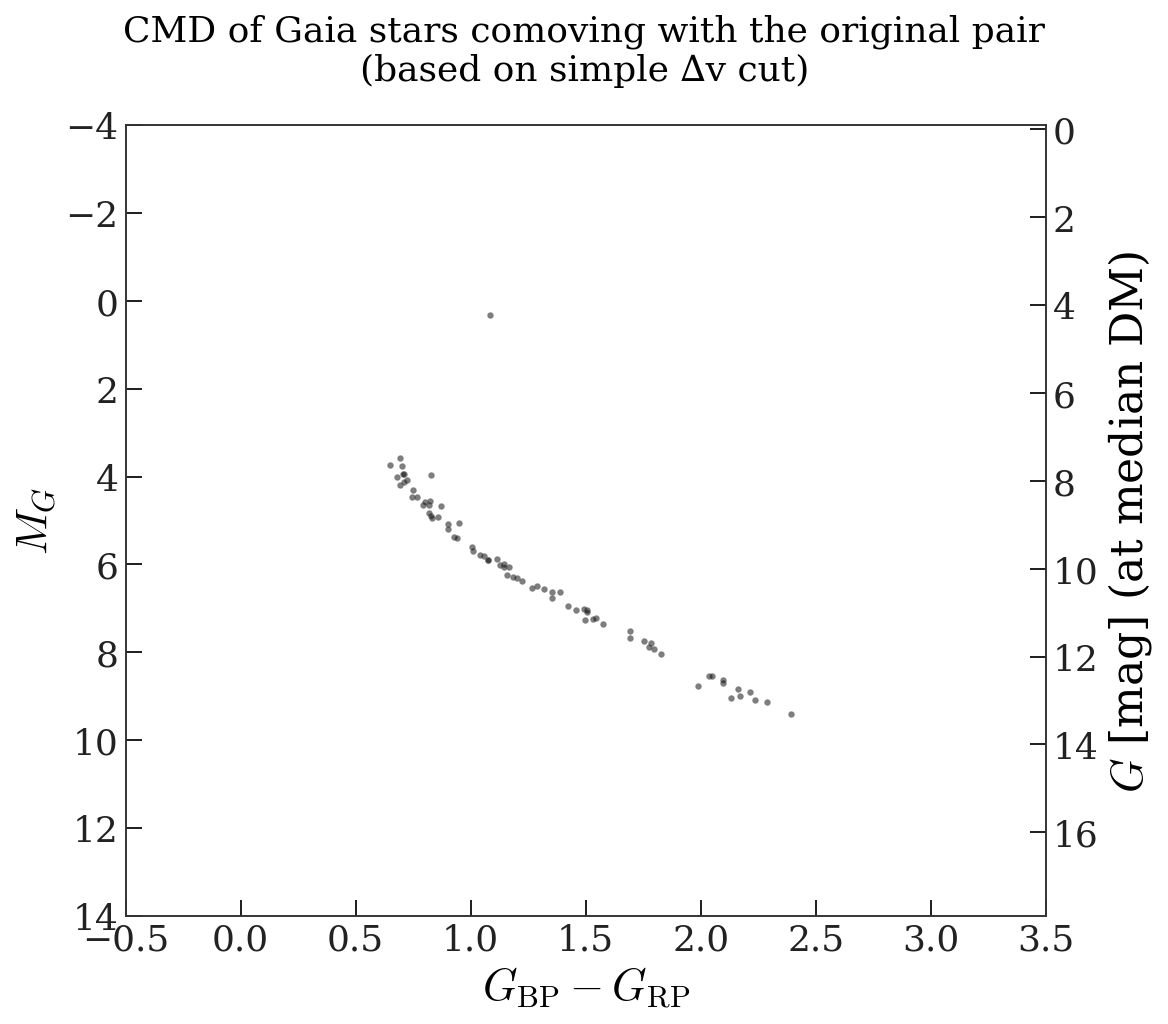

In [5]:
c = g.get_skycoord()

mean_pair_v = 0.5 * (c1.velocity + c2.velocity)
dv = c.velocity - mean_pair_v
dv_mask = dv.norm() < 4*u.km/u.s

mean_pair_x = 0.5 * (c1.cartesian.without_differentials() + 
                     c2.cartesian.without_differentials())
dx = c.cartesian.without_differentials() - mean_pair_x
dx_mask = dx.norm() < 60*u.pc

# Filter out bad astrometric solutions:
ruwe_mask = g.get_ruwe() < 1.4

fig, ax = make_cmd(g[dx_mask & dv_mask & ruwe_mask], alpha=0.5, s=8)
fig.suptitle('CMD of Gaia stars comoving with the original pair\n(based on simple ∆v cut)',
             fontsize=18);

Based on this simple 3D velocity cut, the color–magnitude distribution of stars that are co-moving with the original pair looks like it has a small spread in abundances (i.e. the CMD is very "thin," plus some contamination). This suggested that maybe we found a new moving group, and the original pair are just two of the members. At this point, we passed of a vetted list of targets to Sam Quinn, George Zhou, and Joey Rodriguez, who convinced David Latham to get some TRES spectra of 19 of these stars.

## Lithium abundances (TRES spectra)

Chris Wirth (working with the team above) measured Li equivalent widths for the stars observed with TRES.

In [6]:
li_tbl = at.Table.read('../data/hedges_LI_EW.csv')
li_tbl.rename_column('gaia_source_id', 'source_id')
li_mask = np.isin(g.source_id, li_tbl['source_id'])
assert np.isin(li_tbl['source_id'], g[dx_mask & dv_mask].source_id).sum() == len(li_tbl)

li_joined = GaiaData(at.join(g.data, li_tbl, keys='source_id'))

Here's a Lithium equivalent width (EW) vs. temperature plot for these stars:

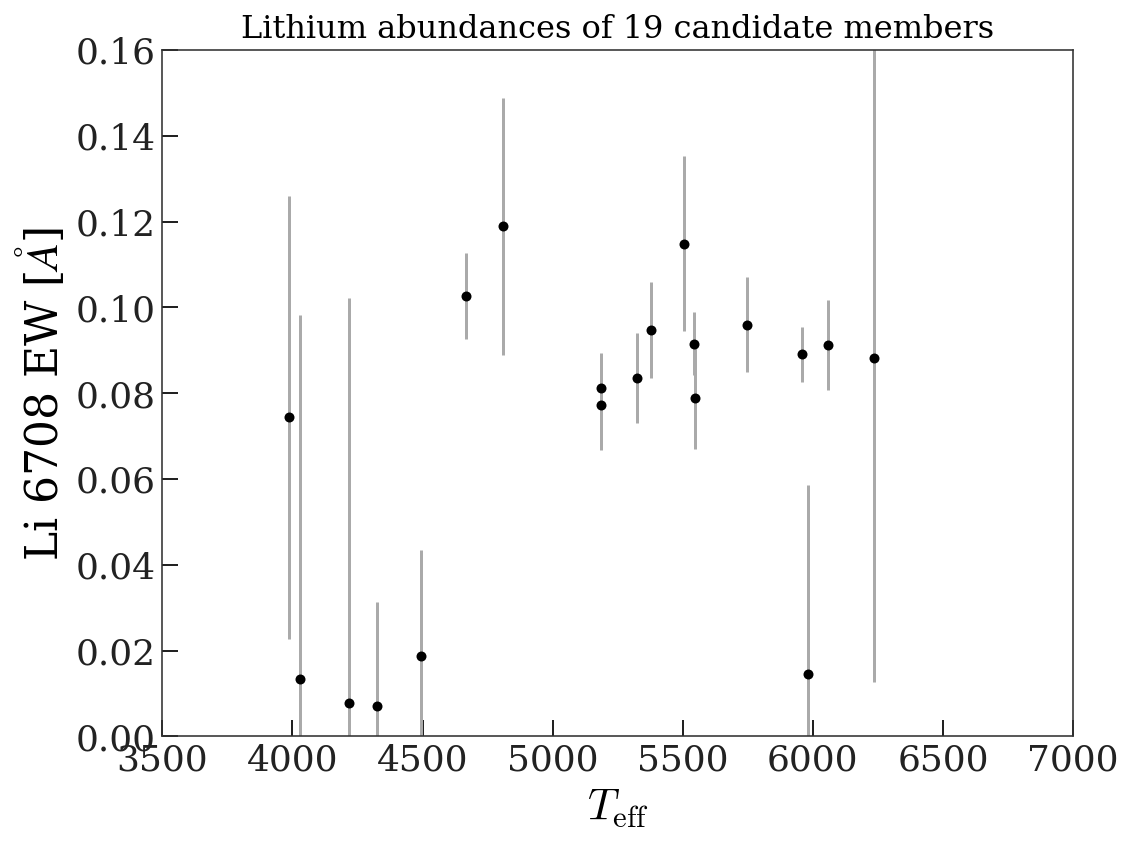

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(li_joined.Teff, li_joined.EW,
            yerr=li_joined.EW_err,
            marker='o', ls='none', ecolor='#aaaaaa')
ax.set_xlim(3500, 7000)
ax.set_ylim(0, 0.16)
ax.set_xlabel(r'$T_{\rm eff}$')
ax.set_ylabel(r'Li 6708 EW [$\AA$]')
ax.set_title("Lithium abundances of 19 candidate members", fontsize=16)
fig.tight_layout()

I am definitely not an expert in Lithium ages, but the fact that most stars have a measurable and comparable Li EW seems promising! Compared to open clusters with measured ages, the values here make these stars slightly older than the Pleiades ($\sim$100 Myr), but younger than the Hyades ($\sim$600 Myr). Here's another look at the same data, coloring points in the CMD by Li EW. It seems like there may be one or two contaminants (the low-Li, T$\sim$6000 K star, and the high-Li, T$\sim$4000 K star), but the EW uncertainties are large for these stars:

(9.0, 3.0)

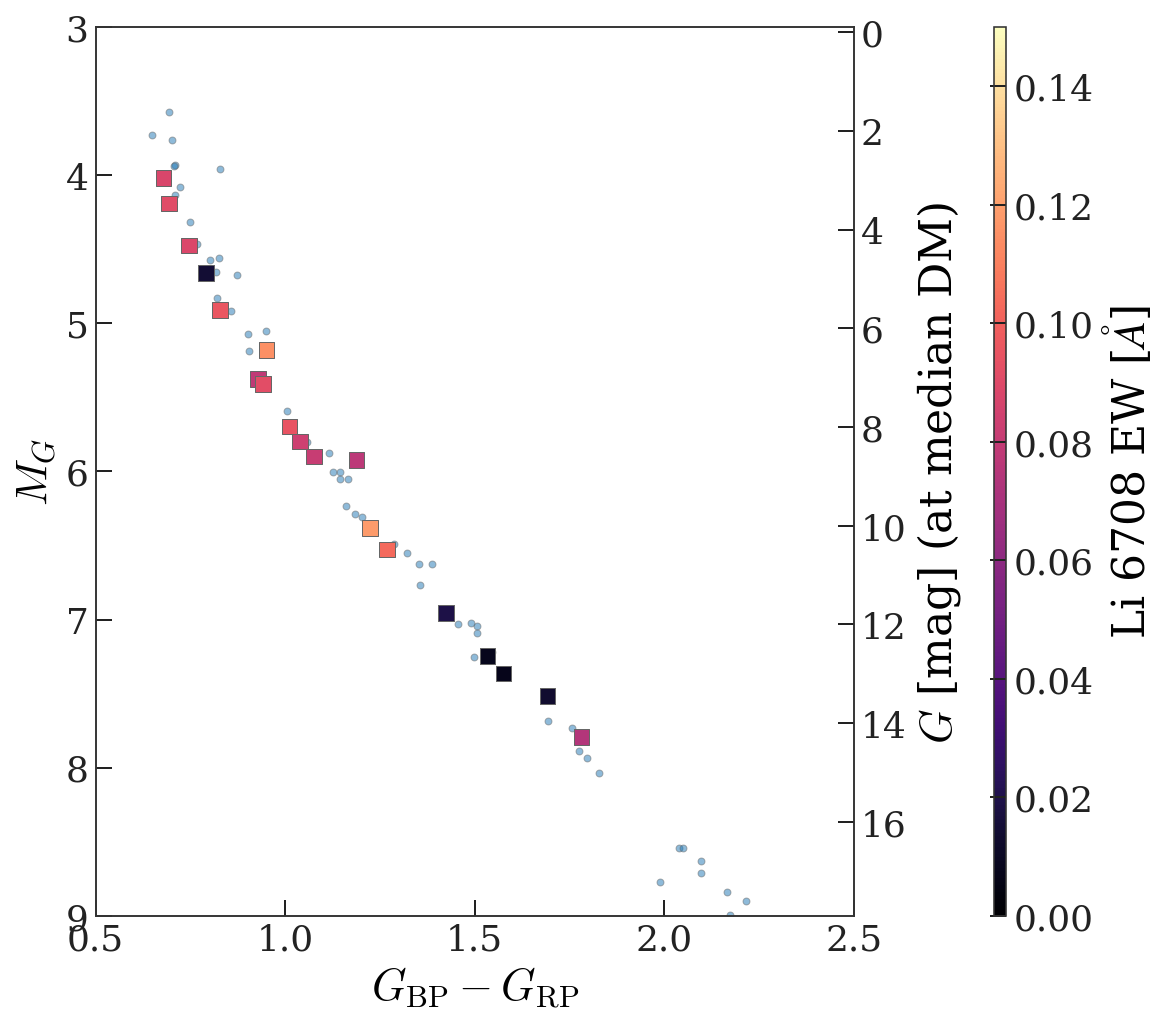

In [8]:
fig, ax = make_cmd(g[dx_mask & dv_mask & ruwe_mask], 
                   alpha=0.5, s=12, color='tab:blue', marker='o')
fig, ax = make_cmd(li_joined, alpha=1, s=60,
                   c=li_joined.EW,
                   norm=mpl.colors.Normalize(0, 0.15),
                   cmap='magma', marker='s',
                   cbar_label=r'Li 6708 EW [$\AA$]',
                   ax=ax, app_mag_twinx=False)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(9, 3)

## Color–magnitude distribution & missing bright/faint stars?

Given the relatively young age of this thing, we expect there to be A and F stars (and many fainter M stars), but the main sequence appears truncated on both ends:

In [9]:
Zsun = 0.0207
M_H = 0.1
Z = Zsun * 10**M_H

isos = dict()
for age in np.array([2, 4, 6])*1e8:
    isos[age] = parsec.get_one_isochrone(age=age, metal=Z, phot='gaiaDR2maiz')

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 42.489 s
  pix_info:   0.519 s
   samples:  29.352 s
      best:   4.754 s
       nan:   0.030 s
      sort:   7.681 s
       idx:   0.153 s


(12.0, -4.0)

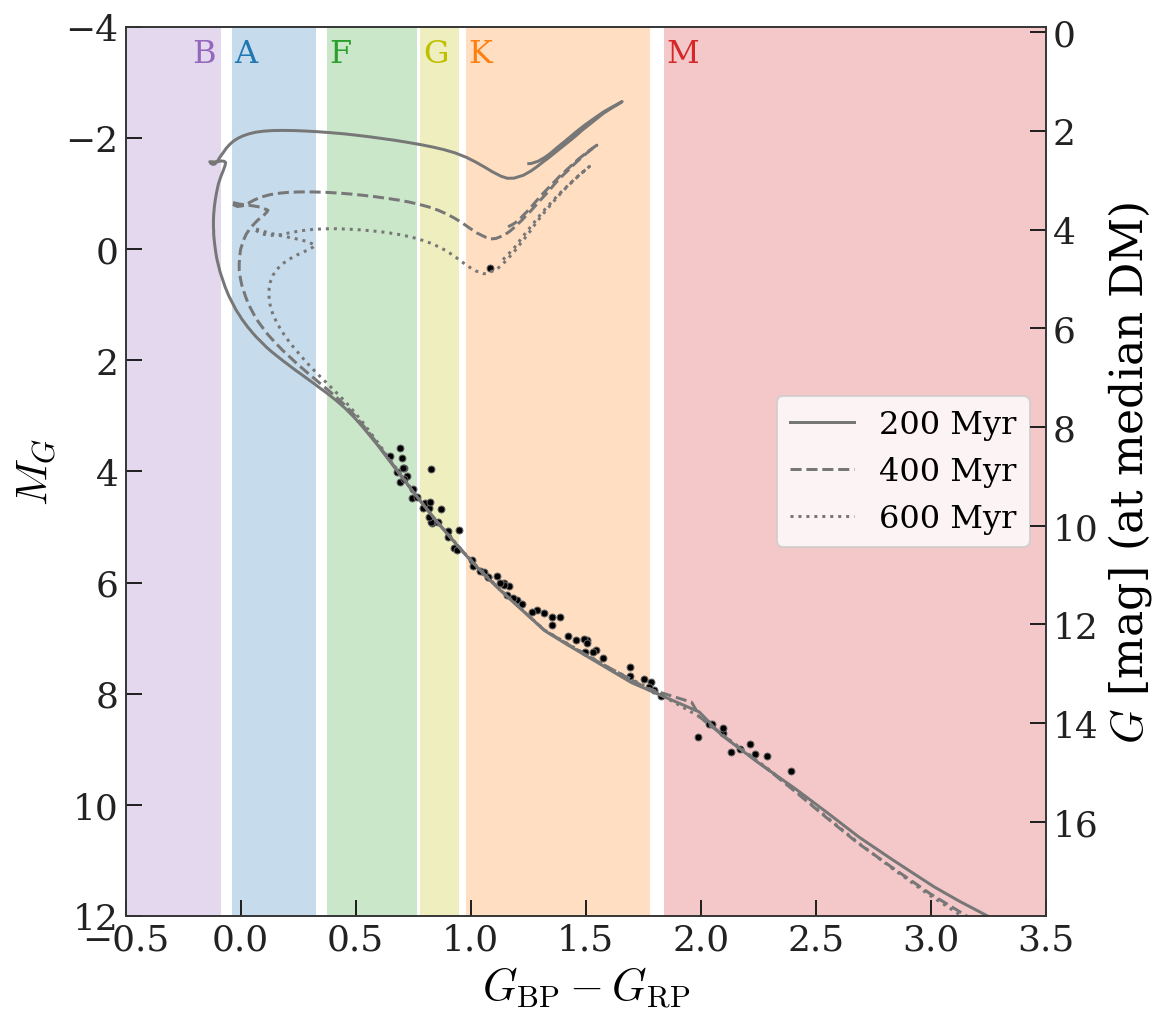

In [10]:
fig, ax = make_cmd(g[dx_mask & dv_mask & ruwe_mask], 
                   alpha=1, s=12, dust_correct=True)

styles = [dict(ls='-'), dict(ls='--'), dict(ls=':')]
for j, (age, iso) in enumerate(isos.items()):
    iso = iso[iso['label'] < 5]
    ax.plot(iso['G_BPbrmag']-iso['G_RPmag'], iso['Gmag'], 
            marker='', color='#777777', label=f'{age/1e6:.0f} Myr', 
            **styles[j])

# from Mamajek: http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
sptypes = {
    'B': ['tab:purple', (-1, -0.087)],
    'A': ['tab:blue', (-0.037, 0.327)],
    'F': ['tab:green', (0.377, 0.767)],
    'G': ['y', (0.782, 0.950)],
    'K': ['tab:orange', (0.98, 1.78)],
    'M': ['tab:red', (1.84, 5)]
}
for sptype, (color, lims) in sptypes.items():
    ax.axvspan(lims[0], lims[1], lw=0, color=color, alpha=0.25, zorder=-100)
    
    if sptype == 'B':
        ax.text(lims[1]-0.02, -4+0.2, 
                sptype, fontsize=16, color=color, alpha=1, 
                zorder=10, ha='right', va='top')
    else:
        ax.text(lims[0]+0.01, -4+0.2, 
                sptype, fontsize=16, color=color, alpha=1, 
                zorder=10, ha='left', va='top')
    
ax.legend(loc='center right', fontsize=16)
ax.set_ylim(12, -4)

The lack of bright/faint stars is because, for this initial selection, we required that all stars have a measured radial velocity from Gaia. For the M stars, Gaia only provides RVs down to G$\sim$12.5. At the bright end, it seems that most stars brighter than G$\sim$6–7 do not have reported radial velocities. 

To extend the comoving sample, we have to move to a fancier way of determining membership. 

## Velocity mixture model & membership

To determine membership probabilities for all stars, including sources with missing dimensions (i.e. radial velocity), I decided to forward model the velocity distribution. Unlike Jonathan Gagné's BANYAN model, I decided not to include positional information in the model (in case this stream is very elongated or irregularly-shaped). 

I started by fitting a 3-component Gaussian mixture model to the velocities of 4,096 (arbitrary) randomly selected Gaia DR2 stars that have measured radial velocities with the goal of capturing the "smooth" part of the Milky Way / field velocity distribution (3 components roughly for the thin disk, thick disk, and halo kinematic popualtions, but in detail each is fairly substructured...). I fit for the means, variances (in each dimension, but assumed diagonal), and mixture weights given parallax, proper motions, and radial velocity, and taking the full Gaia covariance matrix over astrometry into account. (Details are in the Overleaf document - Christina will share a link). For each source, the true (unknown) 3D velocity and true distance to each star have to be included as parameters to infer along with the hyper-parameters (the parameters of each mixture component and the mixture weights).

I freeze the parameters of this 3-component model — let's call it the "field velocity component" — to the maximum a posteriori values, and I construct another 2-component mixture model: one component is the (frozen) field velocity component, and the other component is a single Gaussian centered on the mean velocity of the original pair of comoving stars — the "stream component." I set the dispersion of the stream component to the velocity difference between the two stars (0.6 km/s), but this can be tweaked later. The full mixture model looks like:
$$
    p(v) = w\,p_{\rm stream}(v) + (1-w)\,p_{\rm field}
$$
where now the parameters of both the stream and field velocity distributions are fixed, but the weight $w$ is unknown. The advantage to fixing all of the parameters is that it is not hierarchical: We can treat this as a prior on $v$ and run on each star independently. We can then use the mixture weight, $w$, inferred for each star to compute the posterior probability of belonging to the "stream" component.

I downloaded a 200 pc x 200 pc x 200 pc cube of data from Gaia DR2 brighter than $G < 16$ and centered on the original comoving pair. This sample contains all stars, not just stars that have reported radial velocities, and contains about 230,000 sources (hence why I didn't want to run the hierarchical version of the model above :)). For each star, I use NUTS/HMC (MCMC) to sample over the star's true 3D velocity, true distance, and the mixture weight $w$, then use the samples to estimate the posterior probability of being a "stream" star (based on velocity alone). Here's some visualizations of the high-probability "stream" stars from running this model:

In [11]:
probs = at.Table.read('../cache/probs-clump-200pc-cube.fits')
gprob = GaiaData(at.join(g.data, probs, keys='source_id'))

In [12]:
stream_g = gprob[(gprob.prob > 0.8) & (gprob.get_ruwe() < 1.4)]
stream_c = stream_g.get_skycoord()
print(f'{len(stream_g)} stars have prob > 0.8')

2379 stars have prob > 0.8


First, we'll select only high-probability stars within 60 pc of the original pair and plot a CMD:

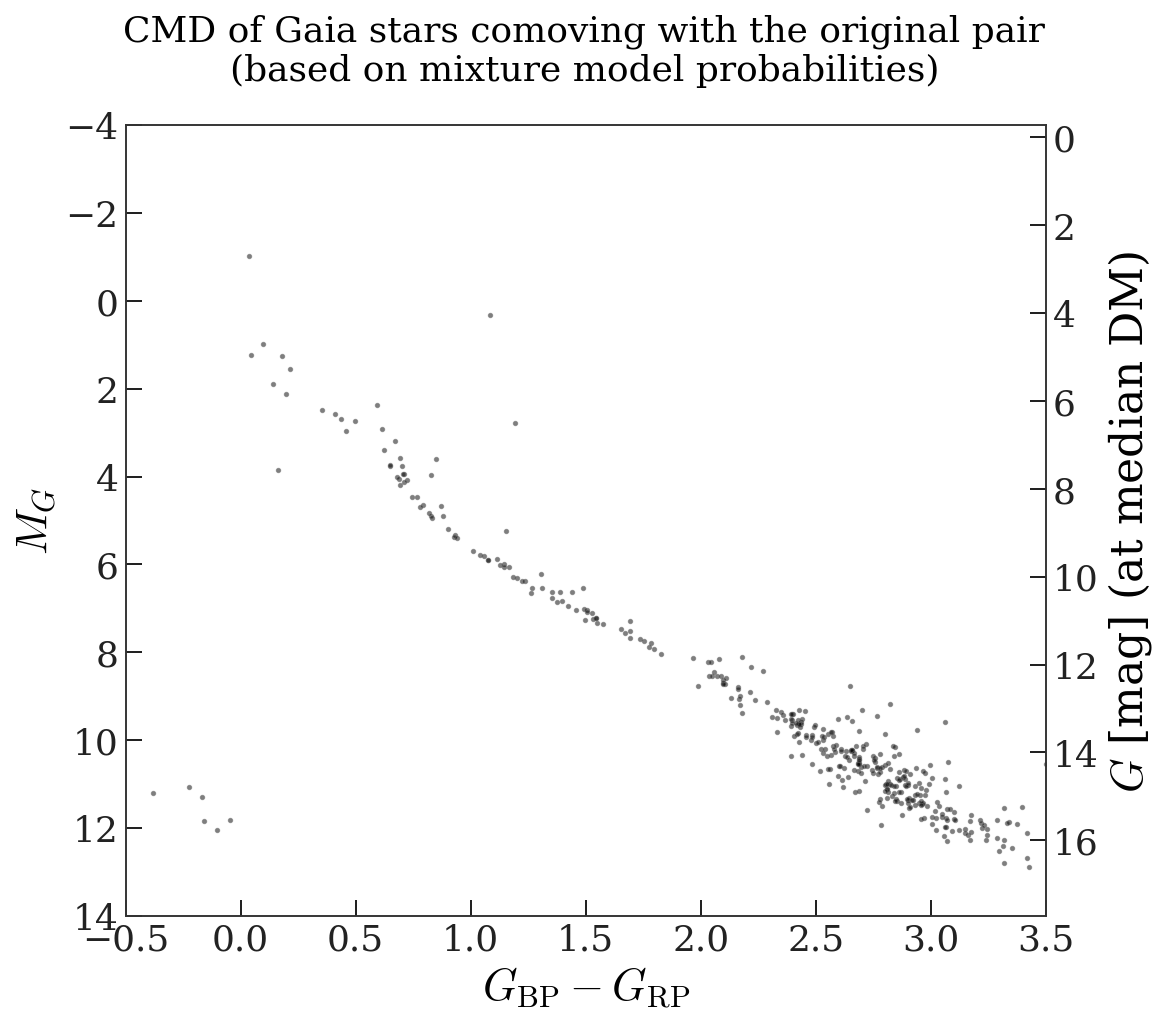

In [13]:
stream_dx = stream_c.cartesian.without_differentials() - mean_pair_x
stream_60pc = stream_dx.norm() < 60*u.pc
fig, ax = make_cmd(stream_g[stream_60pc], 
                   alpha=0.5, s=5)
fig.suptitle('CMD of Gaia stars comoving with the original pair\n(based on mixture model probabilities)',
             fontsize=18);

From the velocity distribution modeling, it looks like we now have both brighter, and fainter main sequence stars! There is definitely more contamination at the bright and faint end as we would expect (see also the white dwarfs): Without radial velocity data, the model has to use proper motions and parallax data. But the tight sequence in the CMD seems to persist even with this larger search for comoving stars — it looks like a comoving, coeval stellar population, what I would call a "stellar stream."

## Galactic spatial distribution of high probability members

Because we didn't use the positional information in our membership criteria, we can make some simple visualizations of the spatial distribution of high-probability members without worrying too much about selection effects.

In [14]:
labels = ['x', 'y', 'z']

def get_xyz_vxyz(c):
    xyz = c.galactic.cartesian.xyz.to_value(u.pc)
    vxyz = c.galactic.velocity.d_xyz.to_value(u.km/u.s)
    return xyz, vxyz

stream_xyz, stream_vxyz = get_xyz_vxyz(stream_c)
stream_has_rv = np.isfinite(stream_g.radial_velocity)

Below, I plot Galactic cartesian coordinate components for high-probability members that have measured Gaia radial velocities. The red markers are the positions of the original pair of stars. The Sun is at (0,0,0) in this coordinate system, Galactic rotation is in +y and the Galactic center is at +x:

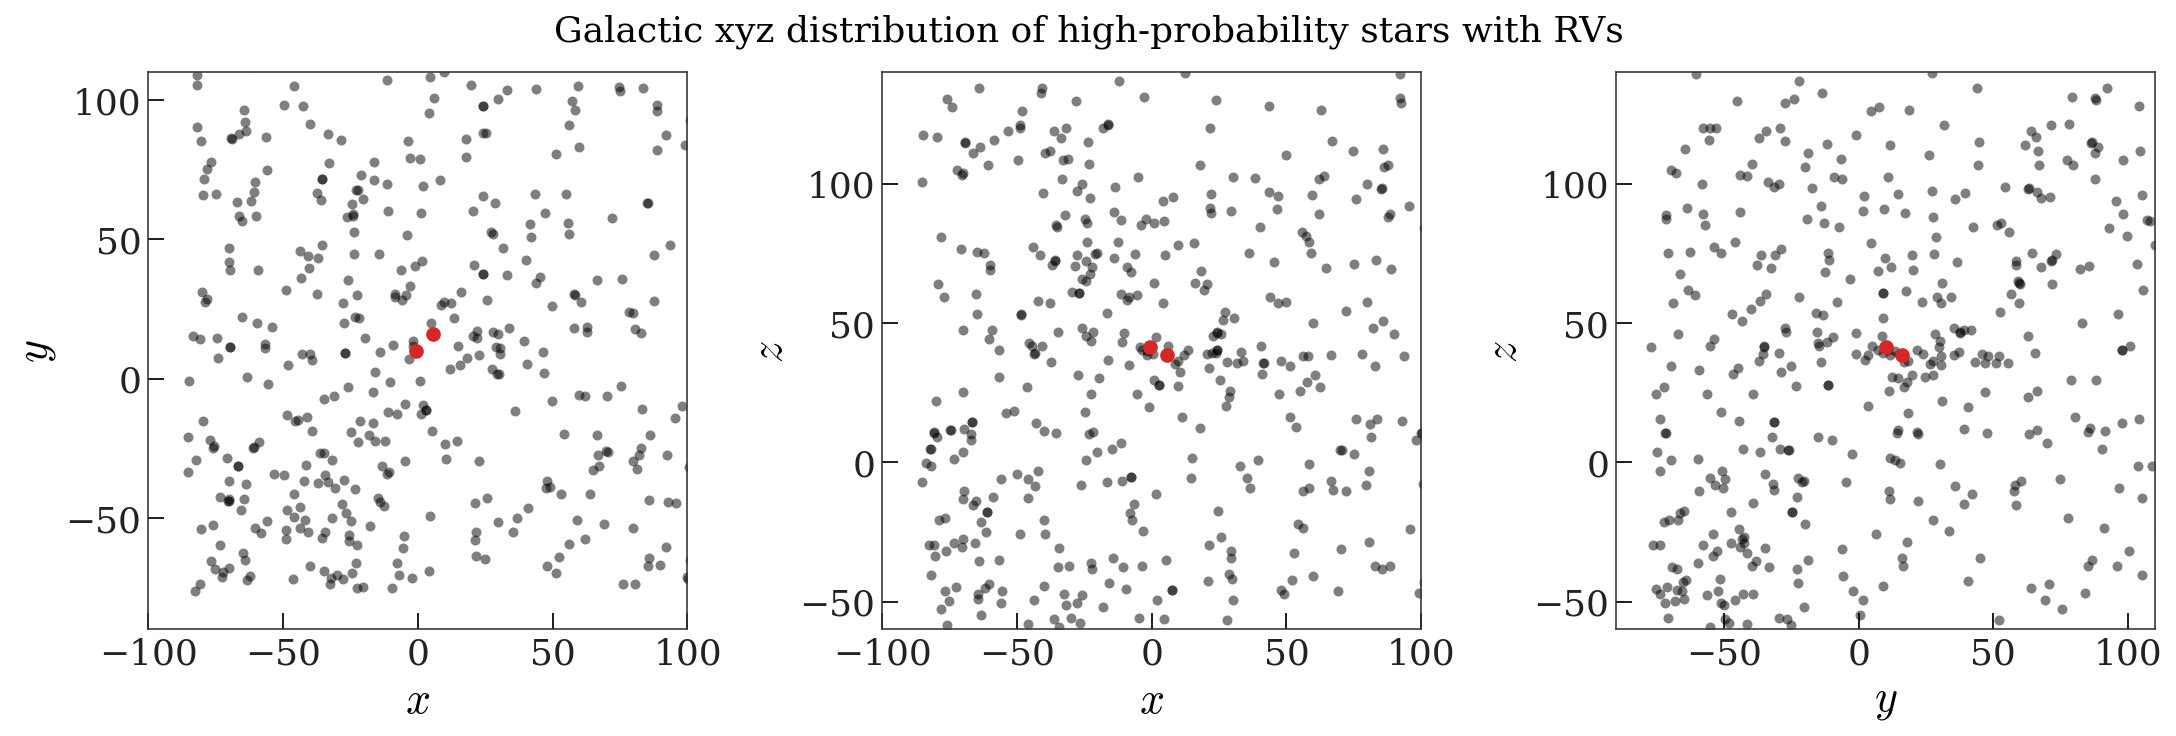

In [15]:
xyz_lims = [(-100, 100), (10-100, 10+100), (40-100, 40+100)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         constrained_layout=True)

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.plot(stream_xyz[i][stream_has_rv],
            stream_xyz[j][stream_has_rv],
            marker='o', ls='none', mew=0, ms=5, alpha=0.5)

    for cc in [c1, c2]:
        _xyz, _ = get_xyz_vxyz(cc)
        ax.scatter(_xyz[i], _xyz[j], color='tab:red', alpha=1, zorder=100, s=40)
    
    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
    
    ax.set_xlim(xyz_lims[i])
    ax.set_ylim(xyz_lims[j])
    
fig.suptitle('Galactic xyz distribution of high-probability stars with RVs',
             fontsize=18);
fig.set_facecolor('w');

I was initially surprised to see so many high-probability velocity "members" spread out throughout this volume, but I guess there are so many disk stars that this isn't too surprising. To my eye, there seems to be a slight over-density of stars near the original pair in the (x,z) and (y,z) panels at roughly constant z value ~41 pc, but I don't see an obvious over-density in the (x,y) plane. We can select this over-density in the z direction and look at the positions of just those stars:

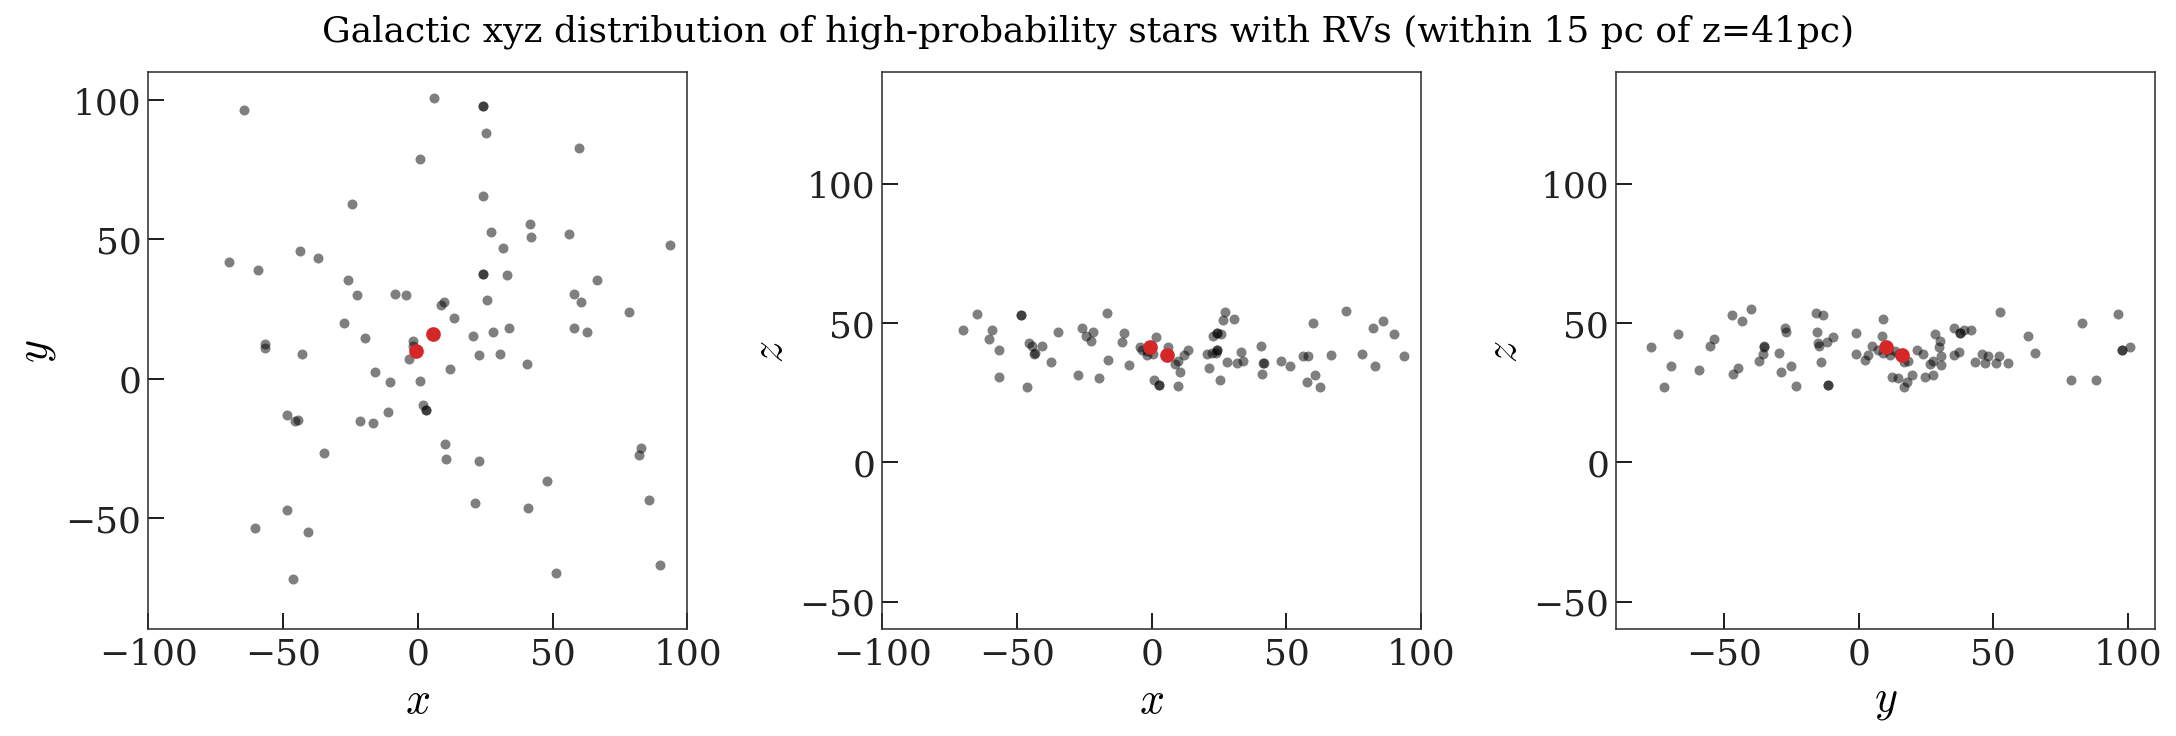

In [16]:
stream_z_mask = np.abs(stream_xyz[2] - 41.) < 15

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         constrained_layout=True)

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.plot(stream_xyz[i][stream_has_rv & stream_z_mask],
            stream_xyz[j][stream_has_rv & stream_z_mask],
            marker='o', ls='none', mew=0, ms=5, alpha=0.5)

    for cc in [c1, c2]:
        _xyz, _ = get_xyz_vxyz(cc)
        ax.scatter(_xyz[i], _xyz[j], color='tab:red', alpha=1, zorder=100, s=40)
    
    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
    
    ax.set_xlim(xyz_lims[i])
    ax.set_ylim(xyz_lims[j])
    
fig.suptitle('Galactic xyz distribution of high-probability stars with RVs (within 15 pc of z=41pc)',
             fontsize=18);
fig.set_facecolor('w')

Here, it does look like there could be a (fairly sparse) over-density of things in the x-y plane, roughly aligned with the diagonal line that points along the separation of the original pair? These plots show only stars that have measured RVs, but what about the full sample?

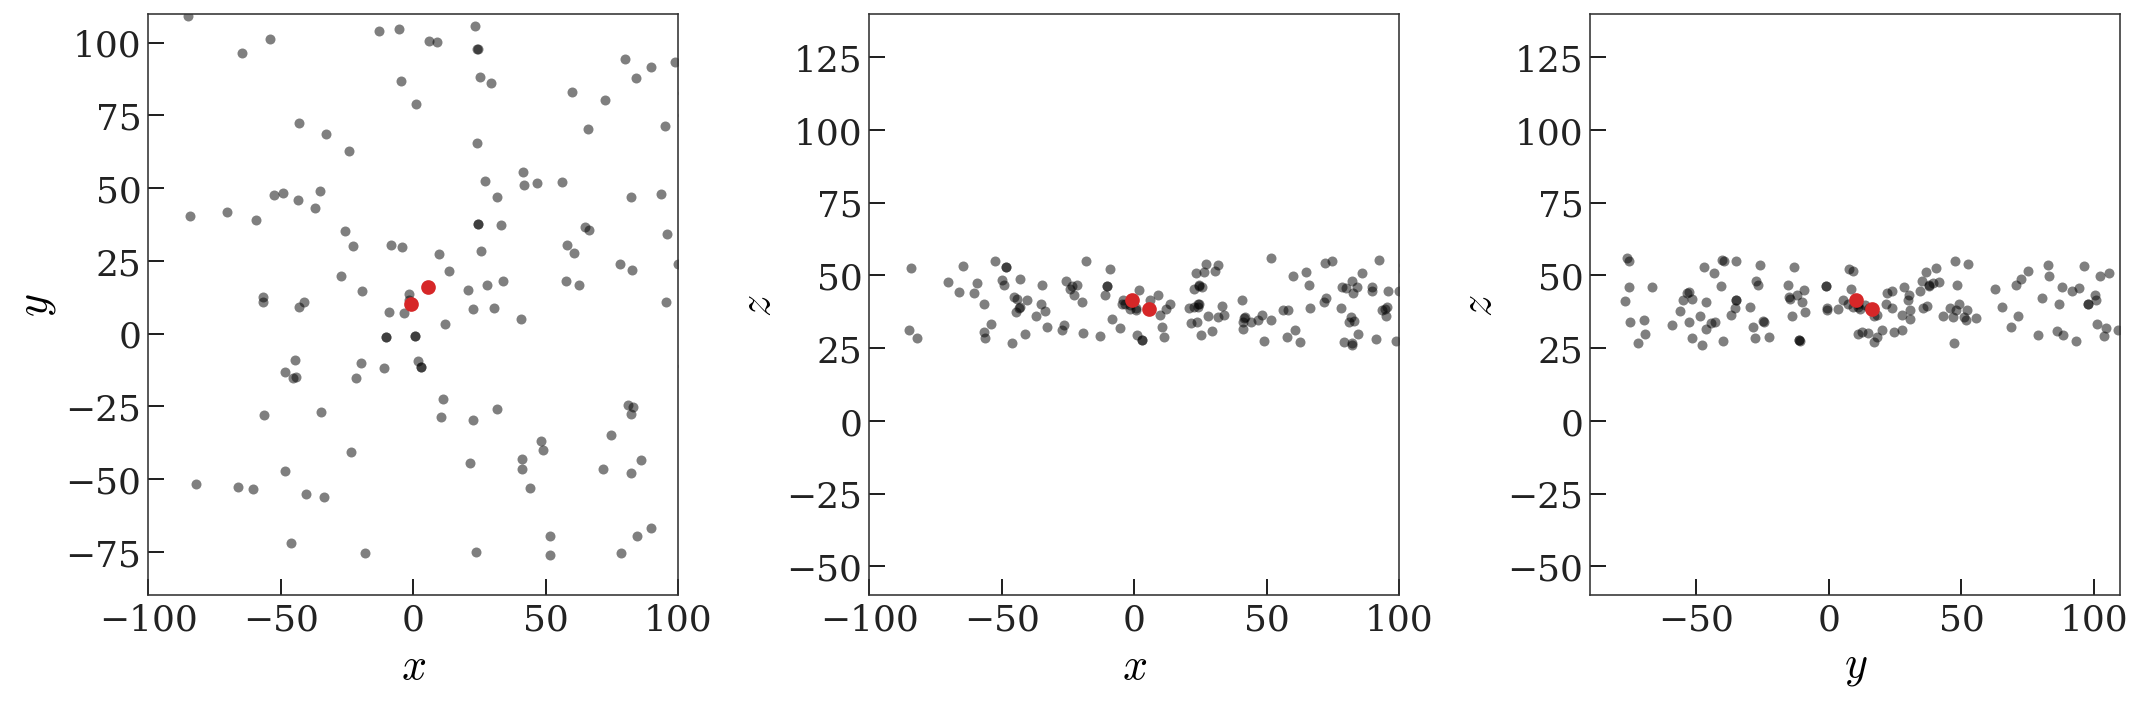

In [17]:
stream_mg, _ = get_MG_BPRP(stream_g)
stream_mag_cut = stream_mg < 9*u.mag  # to remove obvious contamination at the faint end

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.plot(stream_xyz[i][stream_mag_cut & stream_z_mask],
            stream_xyz[j][stream_mag_cut & stream_z_mask],
            marker='o', ls='none', mew=0, ms=5, alpha=0.5)

    for cc in [c1, c2]:
        _xyz, _ = get_xyz_vxyz(cc)
        ax.scatter(_xyz[i], _xyz[j], color='tab:red', alpha=1, zorder=100, s=40)
    
    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
    
    ax.set_xlim(xyz_lims[i])
    ax.set_ylim(xyz_lims[j])
    
fig.tight_layout()
fig.set_facecolor('w')

We can also look at the Galactic velocity of our group relative to the disk population. In the below panels, I plot vx, vy, vz for all stars with radial velocities in the 200pc cube. The red circle is centered on the original pair. In each panel, I select only stars that are within 4 km/s of the pair in the not-shown component of the velocity vector. For example, in the (vx, vy) panel, I only show stars with $|v_z - v_{z, {\rm pair}}| < 4~{\rm km}~{\rm s}^{-1}$).

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


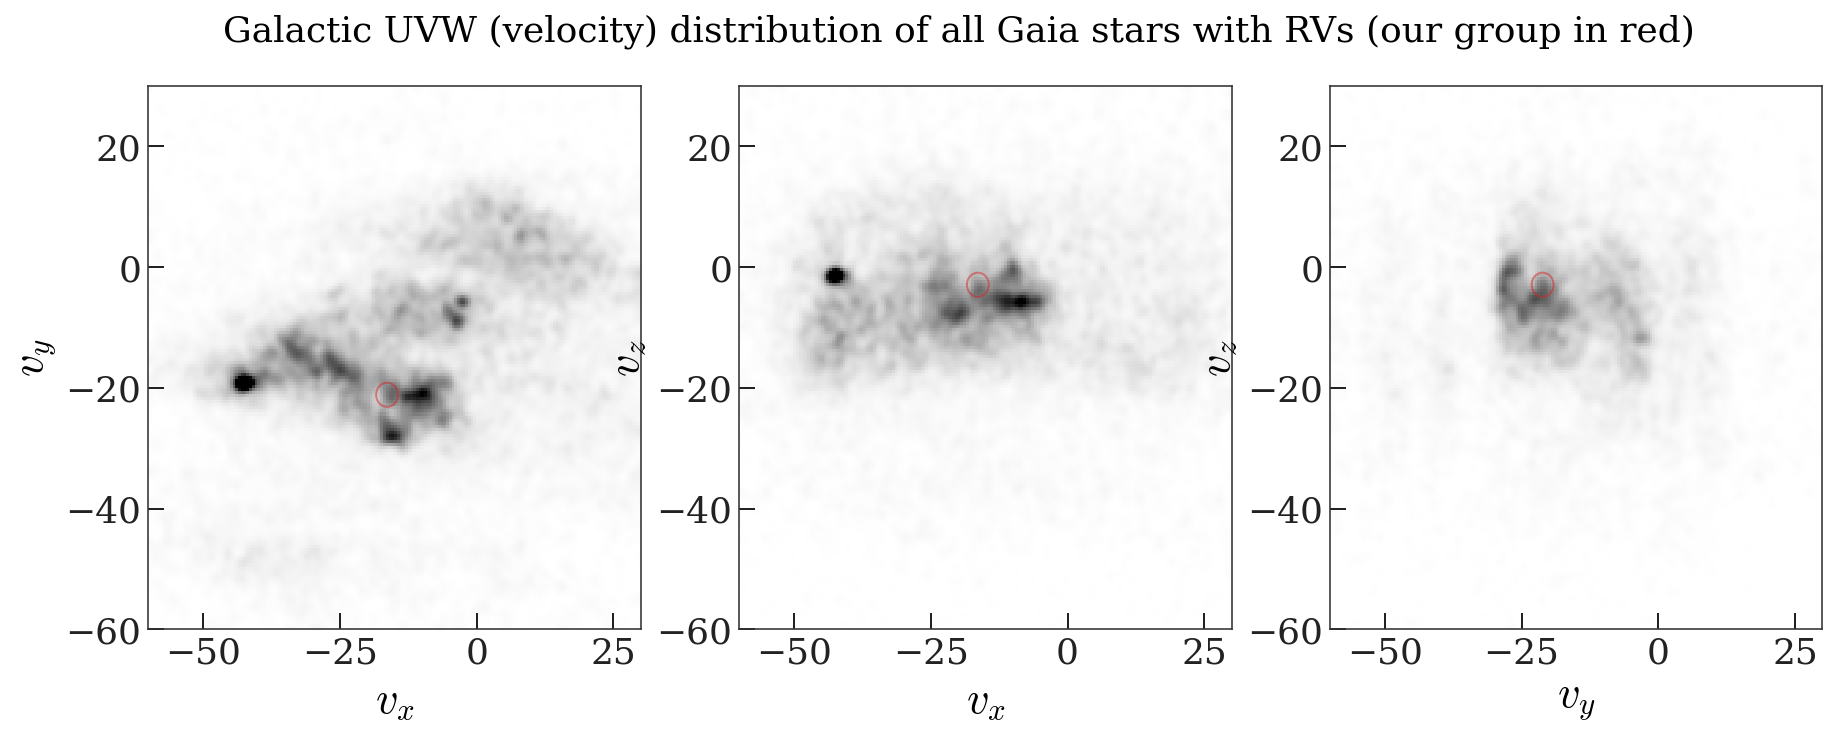

In [18]:
gal = c.galactic
gal_vxyz = gal.velocity.d_xyz.to_value(u.km/u.s)
mean_pair_galv = 0.5 * (c1.galactic.velocity + c2.galactic.velocity)
pair_vxyz = mean_pair_galv.d_xyz.to_value(u.km/u.s)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

not_in = [2, 1, 0]
for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]
    
    mask = np.abs(gal_vxyz[not_in[k]] - pair_vxyz[not_in[k]]) < 4.
    H, xe, ye = np.histogram2d(gal_vxyz[i][mask],
                               gal_vxyz[j][mask],
                               bins=np.arange(-60, 30+1e-3, 0.5))
    H = gaussian_filter(H, sigma=1.5)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', 
                  vmin=0, vmax=6)
    
    circ = mpl.patches.Circle((pair_vxyz[i], pair_vxyz[j]),
                              radius=2, alpha=0.5,
                              facecolor='none', edgecolor='tab:red', lw=1.)
    ax.add_patch(circ)

    ax.set_xlabel(f'$v_{labels[i]}$')
    ax.set_ylabel(f'$v_{labels[j]}$')
    
fig.suptitle('Galactic UVW (velocity) distribution of all Gaia stars with RVs (our group in red)',
             fontsize=18);
fig.set_facecolor('w')

There might be a faint over-density near this velocity, but it's unclear whether this is a distinct group or an extension of a nearby, denser stream.

So, adding in the brigher, and some fainter, stars does not improve the (spatial) signal-to-noise of this structure, and there is only a subtle over-density of stars at the velocity of the pair. Given this, I started to wonder if our stream is a real structure?

## Is this a real, coeval stellar stream / moving group?

The first thing I checked was: If we randomly pick a number of stars from the whole sample and plot them in a CMD, will the main sequence look as tight as our group? (i.e., could we be tricking ourselves by plotting absolute magnitude in the CMD). I randomly sample stars from the same spatial volume as the stream:

In [19]:
np.random.seed(42)
sub_stream_g = stream_g[stream_60pc & stream_z_mask]
sub_g = g[dx_mask]
rand_g = sub_g[np.random.choice(len(sub_g), size=len(sub_stream_g), replace=False)]

Text(0.5, 1.0, 'stream')

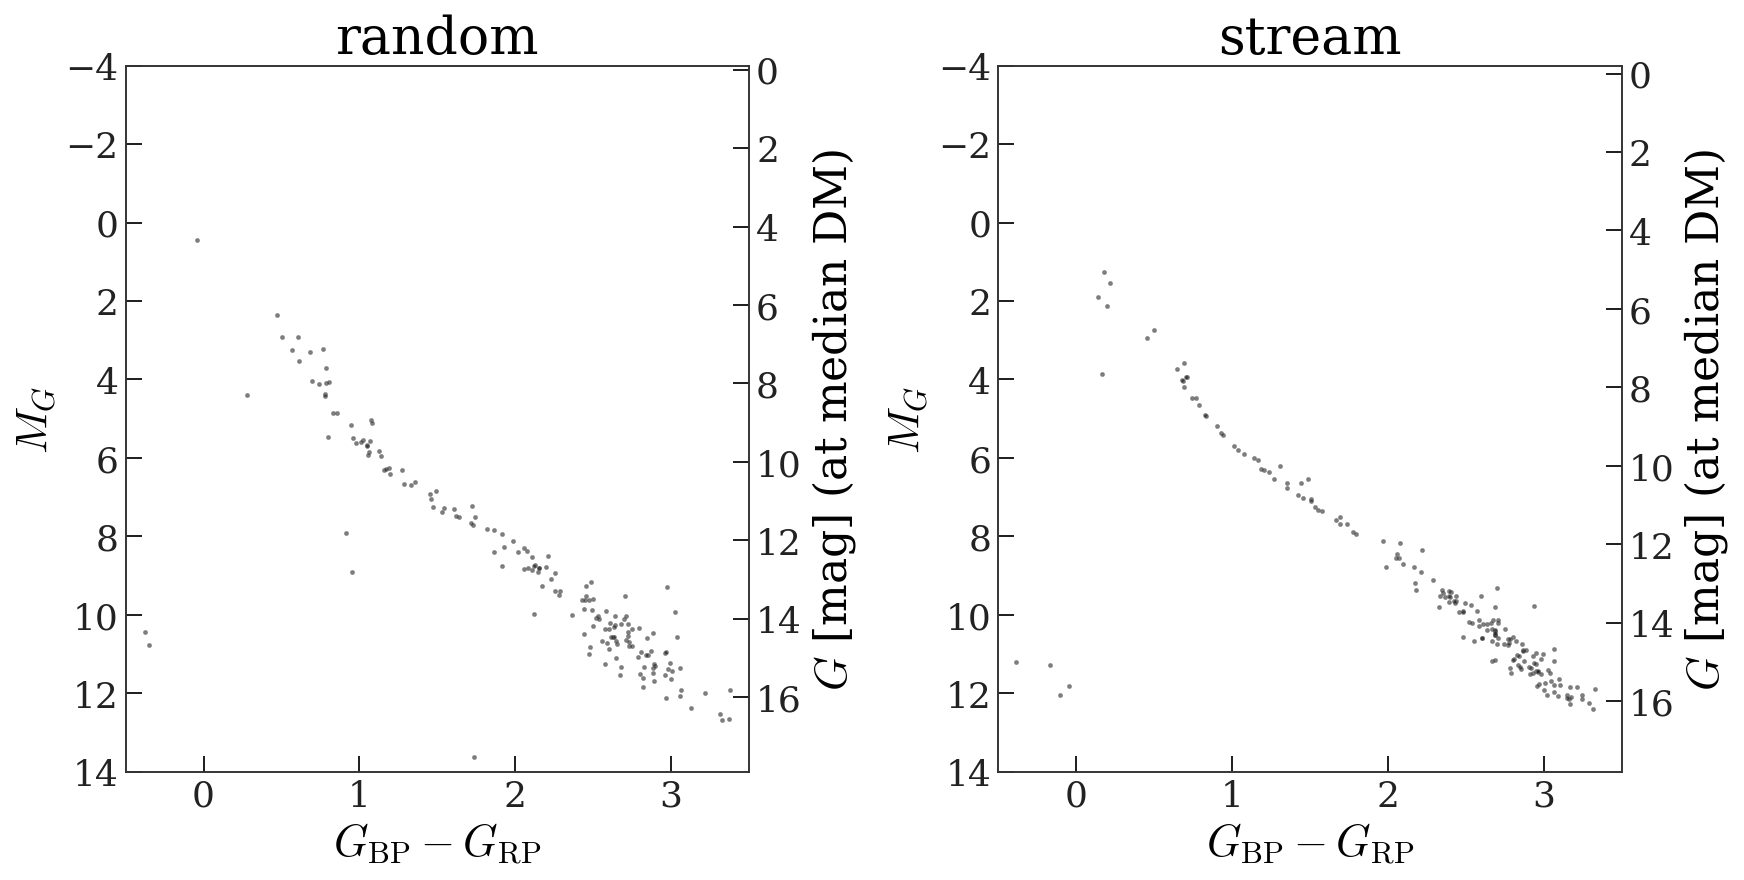

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         constrained_layout=True)
_ = make_cmd(rand_g, ax=axes[0], alpha=0.5, s=4)
axes[0].set_title("random")

_ = make_cmd(sub_stream_g, ax=axes[1], alpha=0.5, s=4)
axes[1].set_title("stream")

At least this looked promising: A random sampling of stars from the 200 pc cube, near the original pair seem to have a spread in chemical properties, but what if we also require that the stars be co-moving with other random velocity vectors? 

The next thing I tried was to choose 9 random velocity vectors and see what the color-magnitude diagram looks like if I also require that stars are co-moving with these random velocity vectors:

In [21]:
# number of random velocity vectors
n_spherel = 9

# Sample random velocity components for the vectors:
# rnd = np.random.seed(111)
rnd = np.random.seed(12345)
xbin = np.random.normal(0, 15, size=n_spherel)
ybin = np.random.normal(-20, 15, size=n_spherel)
zbin = np.random.normal(-10, 5, size=n_spherel)
galv_bin_ctr = np.stack((xbin, ybin, zbin))

Here, I over-plot components of these 9 randomly chosen velocity vectors (different colors) over the UVW / Galactic velocity distribution of stars in the full cube of Gaia data:

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


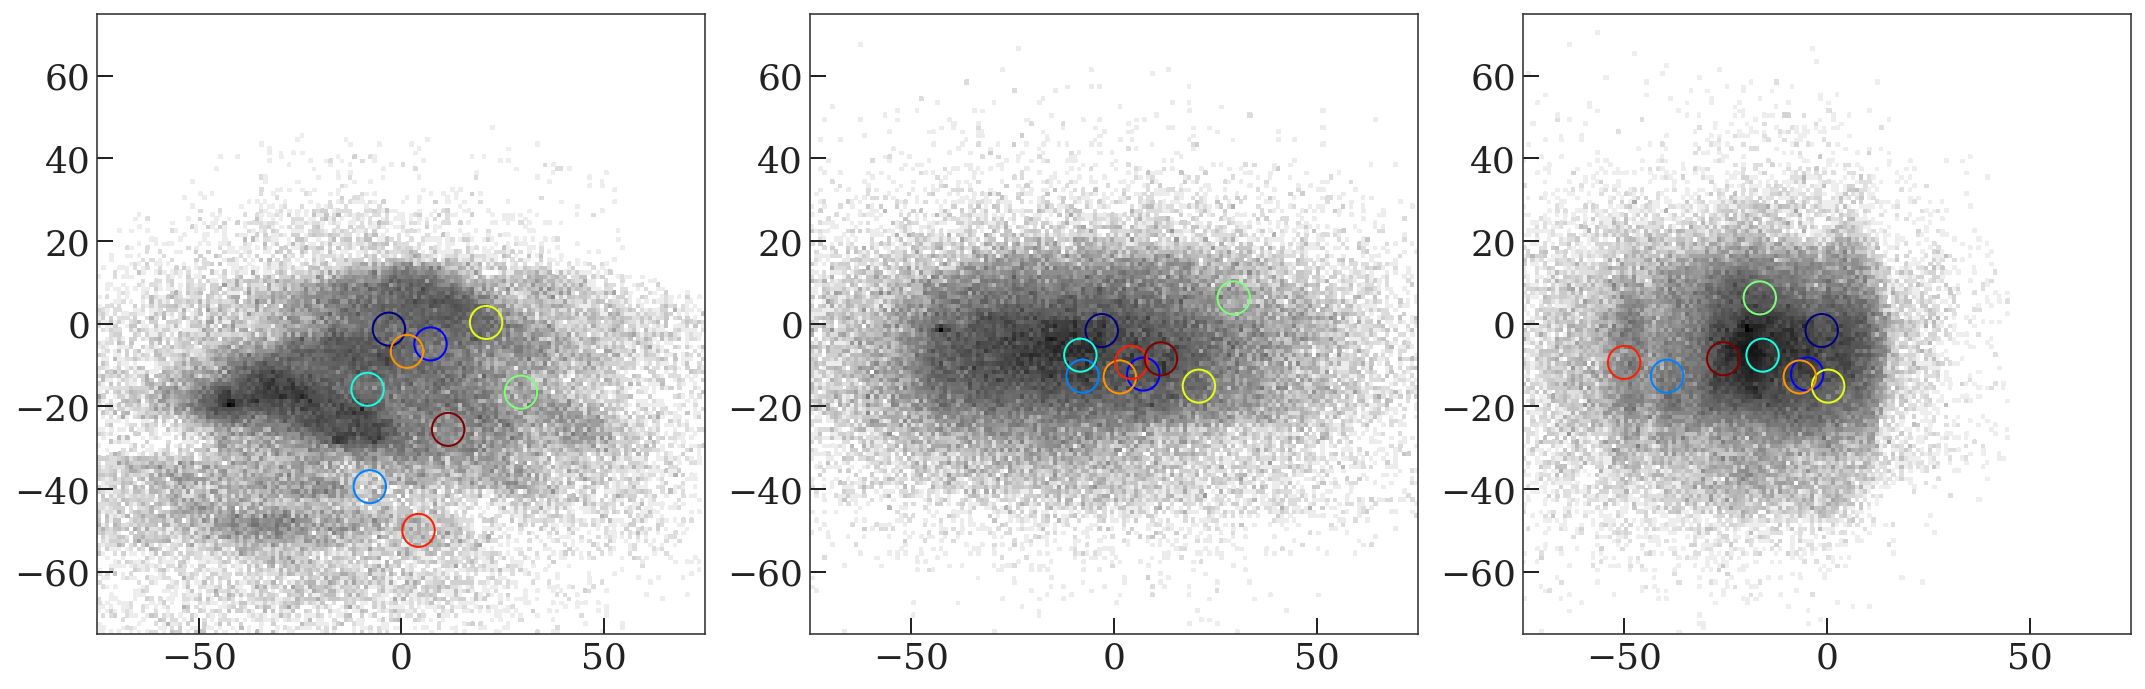

In [22]:
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(0, 8)
spherel_colors = [cmap(norm(n)) for n in range(n_spherel)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

not_in = [2, 1, 0]
for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]
    
    _mask = ((gal_vxyz[not_in[k]] > -75) & 
             (gal_vxyz[not_in[k]] < 75))
    H, xe, ye = np.histogram2d(gal_vxyz[i][_mask], 
                               gal_vxyz[j][_mask],
                               bins=np.arange(-75, 75+1e-3, 1))
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm())
    
    for n in range(n_spherel):
        rec = mpl.patches.Circle((galv_bin_ctr[i, n], galv_bin_ctr[j, n]),
                                 radius=4., lw=1.,
                                 facecolor='none', edgecolor=spherel_colors[n])
        ax.add_patch(rec)
    
fig.tight_layout()
fig.set_facecolor('w')

For each velocity vector, I select stars that have a ∆v < 4 km/s:

In [23]:
boxel_masks = []
for n in range(n_spherel):
    boxel_v = coord.CartesianDifferential(galv_bin_ctr[:, n] * u.km/u.s)
    
    dv = gal.velocity - boxel_v
    boxel_masks.append(dv.norm() < 4*u.km/u.s)
    
[(dx_mask & dv_mask & ruwe_mask).sum() for dv_mask in boxel_masks]

/mnt/home/apricewhelan/.local/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[5, 17, 4, 17, 4, 29, 16, 9, 8]

Here are CMDs for the 9 different random velocity selections. My read on this is: If you select stars that are co-moving with *any* velocity, they seem to form pretty tight sequences, i.e., they look like they are coeval. My question then is: **Is our stellar stream real?**. The local velocity distribution is highly sub-structured, so maybe, no matter what velocity you pick, you will always hit a group of comoving / coeval stars?

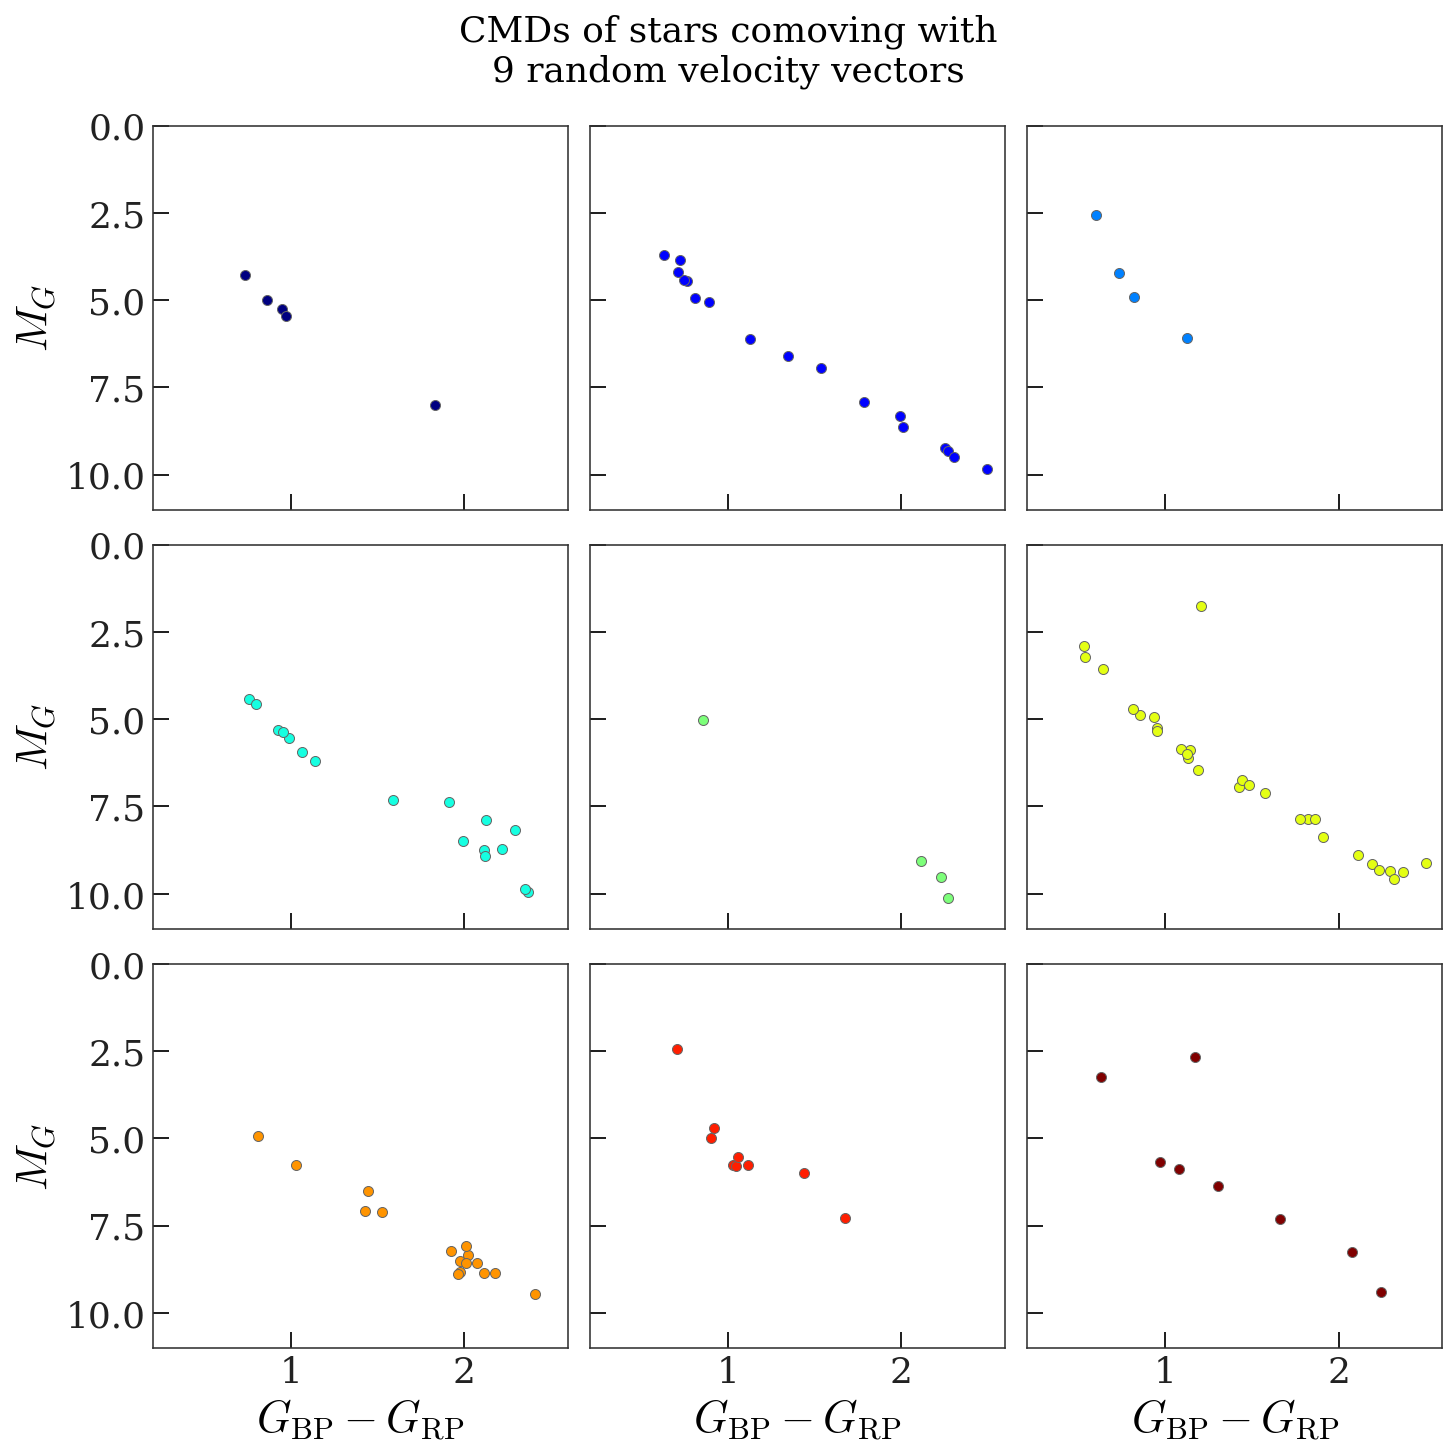

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10),
                         sharex=True, sharey=True,
                         constrained_layout=True)
for i, dv_mask in enumerate(boxel_masks):
    _ = make_cmd(g[dx_mask & dv_mask & ruwe_mask], s=25, 
                 add_labels=False, app_mag_twinx=False, 
                 ax=axes.flat[i], color=spherel_colors[i])

for i in range(3):
    axes[i, 0].set_ylabel('$M_G$')
    axes[-1, i].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$')
    
axes.flat[i].set_xlim(0.2, 2.6)
axes.flat[i].set_ylim(11, 0)

fig.suptitle('CMDs of stars comoving with\n9 random velocity vectors', 
             fontsize=18);

### Given these last few plots, I'm a little confused. How can we actually say whether this is a "real" stream / moving group? Please send thoughts / ideas!